
# Graph Hub/Bottleneck Metrics Dataset (PyG → NetworkX)

Questo notebook crea un dataset di **metriche globali** per grafi di dipendenze **diretti** (PyTorch Geometric → NetworkX)
utili a rilevare la presenza di **hub-like dependency** o **colli di bottiglia**.

**Cosa calcola:**

- Statistiche sulla distribuzione dei gradi (in/out/tot): media, **Gini**, **HHI**, share del **top-k**,
  rapporto **max/mediana**.
- **Centralizzazioni** (stile Freeman) normalizzate su una **stella diretta**: in-degree, out-degree, totale, **betweenness**.
- Regola stile **ARCADE** (hub se degree > μ + σ) e relative quantità.
- **Largest SCC ratio** (dimensione della più grande componente fortemente connessa / n° nodi).
- (Opzionale) Colonna `is_smelly` se presente nell'oggetto `Data`.

> **Nota**: questo notebook non esegue ora il calcolo (non abbiamo i tuoi `.pt` qui). È pronto per essere lanciato nel tuo ambiente.



## Requisiti

- `torch`, `torch_geometric`
- `networkx`, `numpy`, `pandas`, `matplotlib`


In [11]:

import os, glob
from typing import Dict, List
import numpy as np
import pandas as pd
import networkx as nx
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt

# Per una migliore leggibilità dei DataFrame
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)


## Utilità: caricamento PyG e conversione in DiGraph

In [12]:

def load_pyg_data(fp: str) -> Data:
    '''Carica un oggetto PyG Data da file .pt'''
    data = torch.load(fp, map_location="cpu")
    if not isinstance(data, Data):
        raise ValueError(f"File {fp} non contiene un oggetto torch_geometric.data.Data")
    # Normalizza attributi base
    if not hasattr(data, "num_nodes") or data.num_nodes is None:
        data.num_nodes = int(data.x.size(0)) if hasattr(data, "x") else int(data.edge_index.max().item()+1)
    return data

def to_nx_digraph(data: Data) -> nx.DiGraph:
    '''Converte un PyG Data in un NetworkX DiGraph'''
    G = nx.DiGraph()
    n = int(data.num_nodes)
    G.add_nodes_from(range(n))
    if hasattr(data, "edge_index") and data.edge_index is not None and data.edge_index.numel() > 0:
        ei = data.edge_index.cpu().numpy()
        edges = [(int(u), int(v)) for u, v in ei.T.tolist()]
        G.add_edges_from(edges)
    return G


## Metriche di disuguaglianza / concentrazione dei gradi

In [13]:

def gini(arr: np.ndarray) -> float:
    x = np.asarray(arr, dtype=float)
    if x.size == 0 or np.allclose(x, 0):
        return 0.0
    x = np.sort(x)
    n = x.size
    cumx = np.cumsum(x)
    g = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    return float(g)

def hhi(arr: np.ndarray) -> float:
    x = np.asarray(arr, dtype=float)
    s = x.sum()
    if s <= 0:
        return 0.0
    shares = x / s
    return float(np.sum(shares ** 2))  # in (0,1]

def topk_share(arr: np.ndarray, k: int = 3) -> float:
    x = np.sort(np.asarray(arr, dtype=float))[::-1]
    s = x.sum()
    if s <= 0:
        return 0.0
    return float(x[:k].sum() / s)


## Centralizzazione (Freeman) su stella diretta

In [14]:

def centralization(values: np.ndarray, ref_values: np.ndarray) -> float:
    '''Centralizzazione normalizzata rispetto a un grafo di riferimento.'''
    v = np.asarray(values, dtype=float)
    r = np.asarray(ref_values, dtype=float)
    num = float(np.sum(v.max() - v))
    den = float(np.sum(r.max() - r))
    if den <= 0:
        return 0.0
    return num / den

def ref_star_digraph(n: int, mode: str) -> nx.DiGraph:
    '''Stella diretta (per normalizzare centralizzazioni).
    mode: 'in' (leaf->center), 'out' (center->leaf), 'both' (entrambi i versi).'''
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    if n <= 1:
        return G
    c = 0
    leaves = list(range(1, n))
    if mode in ("in", "both"):
        G.add_edges_from([(i, c) for i in leaves])
    if mode in ("out", "both"):
        G.add_edges_from([(c, i) for i in leaves])
    return G

def degree_centrality_total(G: nx.DiGraph) -> np.ndarray:
    '''(in+out)/(2*(n-1)) per DiGraph.'''
    n = G.number_of_nodes()
    if n <= 1:
        return np.zeros(n)
    indeg = np.array([G.in_degree(i) for i in G.nodes()])
    outdeg = np.array([G.out_degree(i) for i in G.nodes()])
    tot = indeg + outdeg
    return tot / float(2 * (n - 1))

def centralizations(G: nx.DiGraph) -> Dict[str, float]:
    n = G.number_of_nodes()
    if n == 0:
        return {k: 0.0 for k in ["centr_in_deg","centr_out_deg","centr_tot_deg","centr_betweenness"]}

    cin  = nx.in_degree_centrality(G) if n > 1 else {i: 0.0 for i in G.nodes()}
    cout = nx.out_degree_centrality(G) if n > 1 else {i: 0.0 for i in G.nodes()}
    ctot = degree_centrality_total(G) if n > 1 else np.zeros(n)
    cbet = nx.betweenness_centrality(G, normalized=True) if n > 2 else {i: 0.0 for i in G.nodes()}

    vin  = np.array([cin[i]  for i in G.nodes()])
    vout = np.array([cout[i] for i in G.nodes()])
    vtot = np.asarray(ctot)
    vbet = np.array([cbet[i] for i in G.nodes()])

    G_in   = ref_star_digraph(n, "in")
    G_out  = ref_star_digraph(n, "out")
    G_both = ref_star_digraph(n, "both")

    rin   = np.array([nx.in_degree_centrality(G_in)[i]   for i in G_in.nodes()])  if n>1 else np.zeros(n)
    rout  = np.array([nx.out_degree_centrality(G_out)[i] for i in G_out.nodes()]) if n>1 else np.zeros(n)
    rtot  = degree_centrality_total(G_both) if n>1 else np.zeros(n)
    rbet  = np.array([nx.betweenness_centrality(G_both, normalized=True)[i] for i in G_both.nodes()]) if n>2 else np.zeros(n)

    return {
        "centr_in_deg":  centralization(vin,  rin),
        "centr_out_deg": centralization(vout, rout),
        "centr_tot_deg": centralization(vtot, rtot),
        "centr_betweenness": centralization(vbet, rbet),
    }


## Metriche globali dal grafo

In [15]:

def graph_metrics(G: nx.DiGraph) -> Dict[str, float]:
    n = G.number_of_nodes()
    m = G.number_of_edges()

    indeg = np.array([G.in_degree(i) for i in G.nodes()], dtype=float)
    outdeg = np.array([G.out_degree(i) for i in G.nodes()], dtype=float)
    totdeg = indeg + outdeg

    metrics = {
        "n_nodes": float(n),
        "n_edges": float(m),
        "avg_in_deg": float(indeg.mean() if n>0 else 0.0),
        "avg_out_deg": float(outdeg.mean() if n>0 else 0.0),
        "avg_tot_deg": float(totdeg.mean() if n>0 else 0.0),
        "gini_in_deg": gini(indeg),
        "gini_out_deg": gini(outdeg),
        "gini_tot_deg": gini(totdeg),
        "hhi_in_deg": hhi(indeg),
        "hhi_out_deg": hhi(outdeg),
        "hhi_tot_deg": hhi(totdeg),
        "maxdeg_share": float(totdeg.max()/totdeg.sum()) if totdeg.sum()>0 else 0.0,
        "top3deg_share": topk_share(totdeg, k=3),
        "max_over_median_deg": float(totdeg.max() / (np.median(totdeg) + 1e-8)) if n>0 else 0.0,
    }

    # Centralizzazioni (Freeman) normalizzate su stella diretta
    metrics.update(centralizations(G))

    # Regola tipo ARCADE: hub se degree > media + std (su totdeg)
    mu, sigma = float(totdeg.mean()), float(totdeg.std(ddof=0))
    thr = mu + sigma
    hubs_arcade = int(np.sum(totdeg > thr))
    degree_outlier_ratio = float(hubs_arcade / n) if n>0 else 0.0
    metrics.update({
        "thr_mu_plus_sigma_deg": thr,
        "num_hubs_arcade": float(hubs_arcade),
        "ratio_hubs_arcade": degree_outlier_ratio,
    })

    # Largest strongly connected component (SCC) ratio
    try:
        sccs = list(nx.strongly_connected_components(G))
        largest_scc = max((len(c) for c in sccs), default=0)
    except Exception:
        largest_scc = 0
    metrics["largest_scc_ratio"] = float(largest_scc / n) if n>0 else 0.0

    return metrics


## Calcolo su file `.pt` e costruzione del dataset

In [16]:

def compute_metrics_for_file(fp: str) -> Dict[str, float]:
    data = load_pyg_data(fp)
    G = to_nx_digraph(data)
    row = graph_metrics(G)
    # label opzionale se presente (0/1)
    if hasattr(data, "is_smelly"):
        try:
            row["is_smelly"] = float(data.is_smelly.item())
        except Exception:
            row["is_smelly"] = float(data.is_smelly)
    else:
        row["is_smelly"] = np.nan
    row["file"] = os.path.basename(fp)
    return row

def build_dataset(filepaths: List[str]) -> pd.DataFrame:
    rows: List[Dict[str, float]] = []
    for fp in filepaths:
        try:
            rows.append(compute_metrics_for_file(fp))
        except Exception as e:
            print(f"[WARN] Skippato {fp}: {e}")
    df = pd.DataFrame(rows)
    cols_first = ["file","is_smelly","n_nodes","n_edges"]
    other_cols = [c for c in df.columns if c not in cols_first]
    df = df[cols_first + other_cols]
    return df


## Imposta il path dei grafi (`.pt`)

In [17]:

# Modifica BASE_PATH con la tua directory dei grafi PyG
BASE_PATH = "dataset/graph_features"

all_files = glob.glob(os.path.join(BASE_PATH, "*.pt"))
print(f"Trovati {len(all_files)} file .pt nel path {BASE_PATH}")


Trovati 2023 file .pt nel path dataset/graph_features


## Costruisci il dataset di metriche

In [18]:

if len(all_files) > 0:
    df = build_dataset(all_files)
    print(f"Righe: {len(df)}, Colonne: {len(df.columns)}")
    out_csv = "graph_hub_metrics.csv"
    df.to_csv(out_csv, index=False)
    print(f"Salvato: {out_csv}")
    try:
        display(df.head())
        try:
            from caas_jupyter_tools import display_dataframe_to_user
            display_dataframe_to_user("Graph Hub Metrics", df)
        except Exception:
            pass
    except NameError:
        print(df.head())
else:
    print("Nessun file .pt trovato: aggiorna BASE_PATH e riesegui.")


Righe: 2023, Colonne: 24
Salvato: graph_hub_metrics.csv


,file,is_smelly,n_nodes,n_edges,avg_in_deg,avg_out_deg,avg_tot_deg,gini_in_deg,gini_out_deg,gini_tot_deg,hhi_in_deg,hhi_out_deg,hhi_tot_deg,maxdeg_share,top3deg_share,max_over_median_deg,centr_in_deg,centr_out_deg,centr_tot_deg,centr_betweenness,thr_mu_plus_sigma_deg,num_hubs_arcade,ratio_hubs_arcade,largest_scc_ratio
0,opennlp-hl-23-24-25_762_0314_2012_7d91ff2e.pt,0.0,8.0,15.0,1.875000,1.875000,3.750000,0.441667,0.491667,0.250000,0.217778,0.280000,0.151111,0.233333,0.566667,2.000000,0.510204,0.836735,0.309524,0.047619,5.463914,1.0,0.125000,0.125000
1,commons-lang-hl-23-24-25_861_0146_7588_7e808a8...,1.0,11.0,26.0,2.363636,2.363636,4.727273,0.412587,0.503497,0.262238,0.147929,0.207101,0.113166,0.192308,0.461538,2.500000,0.510000,0.840000,0.322222,0.045000,7.066306,2.0,0.181818,0.090909
2,commons-lang-hl-23-24-25_1766_0114_7664_7d8433...,0.0,8.0,22.0,2.750000,2.750000,5.500000,0.420455,0.340909,0.193182,0.198347,0.181818,0.140496,0.204545,0.522727,1.800000,0.530612,0.693878,0.333333,0.190476,7.436492,1.0,0.125000,0.500000
3,commons-lang-hl-23-24-25_265_0536_8429_7d419b9...,0.0,9.0,28.0,3.111111,3.111111,6.222222,0.357143,0.404762,0.222222,0.163265,0.178571,0.128827,0.178571,0.482143,1.666667,0.687500,0.687500,0.303571,0.102679,8.706742,2.0,0.222222,0.333333
4,opennlp-hl-23-24-25_4665_0300_2065_6fde608c.pt,1.0,21.0,94.0,4.476190,4.476190,8.952381,0.422492,0.483283,0.283688,0.078316,0.095292,0.060208,0.106383,0.281915,2.500000,0.447500,0.815000,0.305263,0.132691,13.555446,3.0,0.142857,0.333333


## (Opzionale) Grafico: conteggio sub-graph `smelly` vs `clean`

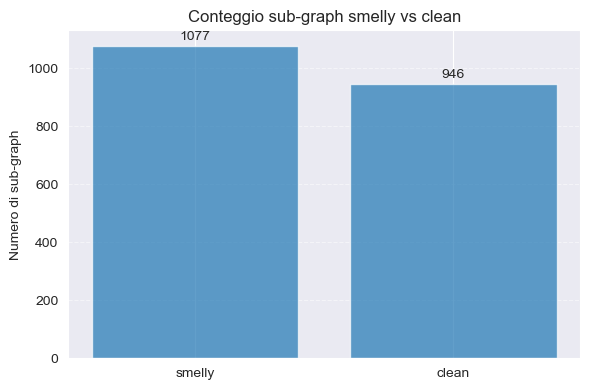

In [19]:

# Usa solo matplotlib, un singolo grafico, nessun colore esplicito.
if len(all_files) > 0:
    counts = {"smelly": 0, "clean": 0}
    for fp in all_files:
        data = load_pyg_data(fp)
        try:
            label = int(data.is_smelly.item())
        except Exception:
            label = int(data.is_smelly) if hasattr(data, "is_smelly") else None
        if label is None:
            continue
        if label == 1:
            counts["smelly"] += 1
        else:
            counts["clean"] += 1

    labels = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(6,4))
    bars = plt.bar(labels, values, alpha=0.7)
    plt.ylabel("Numero di sub-graph")
    plt.title("Conteggio sub-graph smelly vs clean")
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h + max(values)*0.01, str(h),
                 ha="center", va="bottom")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("Salta grafico: nessun file .pt trovato.")
